<a href="https://colab.research.google.com/github/rtheman/CLV/blob/master/2_Code/CLV__UK_online_retailer_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Lifetime Value

**OBJECTIVE**.  To quantify customers in a non-contractual business settings.

**Data**: https://www.kaggle.com/roshansharma/online-retail?select=online+retail.csv

NOTE:
1. `InvoiceNo` is alphanumeric
1. `InvoiceDate` in formatted as dd.mm/yy h.mm

**REFERENCES**

Videos
- Peter Fader [video](https://www.youtube.com/watch?v=guj2gVEEx4s)

Examples
- Collin Ching's [Medium blog](https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf)
- Luca De Angelis [Medium blog](https://towardsdatascience.com/predicting-customer-lifetime-value-with-buy-til-you-die-probabilistic-models-in-python-f5cac78758d9).  Great write up.
- Gamma-Gamma [example01](https://books.google.com/books?id=_xamDwAAQBAJ&pg=PA99&lpg=PA99&dq=GammaGammaFitter&source=bl&ots=s-SdLrKpZP&sig=ACfU3U2ChOfkDkgzfGdu_6PhAizXg-T80Q&hl=en&sa=X&ved=2ahUKEwje3IaBud_pAhX7HzQIHaqpCUgQ6AEwBXoECAoQAQ#v=onepage&q=GammaGammaFitter&f=false)
- Gamma-Gamma [example02](https://www.mikulskibartosz.name/predicting-customer-lifetime-value-using-the-pareto-nbd-model-and-gamma-gamma-model/) by Bartosz Mikulski

# 1.) Data Extraction

**REFERENCES**
- [BigQuery documentation](https://cloud.google.com/bigquery/docs)
- [library reference documentation](https://googleapis.dev/python/bigquery/latest/index.html#).

Example. https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=ONI1Xo0-KtAD

## a.- Connecting to BigQuery

### i. Set Credentials

In [121]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### ii. Enable data table display

Colab includes the `google.colab.data_table` package that can be used to display large pandas dataframes as an interactive data table. It can be enabled with:

In [0]:
%load_ext google.colab.data_table

To disable, simply
`%unload_ext google.colab.data_table`

### iii. Set BigQuery project ID

In [0]:
# Declare the Cloud project ID which will be used throughout this notebook
project_id = "rleung-sandbox"

# Set table_id to the ID of the destination table.
table_name = "online_retailer_UK"
table_id = project_id + "." + table_name

## b.- Query Data

We will use BigQuery via `magics` as well as the `google.cloud.bigquery` library.  

The `magics` command runs query and either displays the result or saves it to a variable as a `DataFrame`.

In [0]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

### i. Num. of records

In [125]:
# BigQuery via magics

%%bigquery --project rleung-sandbox
SELECT 
  COUNT(*) as total
FROM `rleung-sandbox.CLV.online_retailer_UK`

,total
0,532619


In [126]:
# BigQuery via google-cloud-bigquery

row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `rleung-sandbox.CLV.online_retailer_UK`
''').to_dataframe().total[0]

print('Full dataset has %d rows' % row_count)

Full dataset has 532619 rows


### ii. Num. of customers

In [127]:
# BigQuery via magics

%%bigquery --project rleung-sandbox
SELECT
    COUNT(DISTINCT CustomerID) as total
# FROM `rleung-sandbox.CLV.online_retailer_UK`
FROM `rleung-sandbox.CLV.online_retailer_UK`

,total
0,4339


In [128]:
# BigQuery via google-cloud-bigquery

cust_count = client.query('''
    SELECT
        COUNT(DISTINCT CustomerID) as total
    FROM `rleung-sandbox.CLV.online_retailer_UK`
''').to_dataframe().total[0]

print('There are %d customers' % cust_count)

There are 4339 customers


### iii. Date Range

In [0]:
holdout_date = '2011-10-10'

In [130]:
# BigQuery via magics

%%bigquery --project rleung-sandbox
select 
    a.first_purchase_date
    , a.last_purchase_date
    , date_diff(a.last_purchase_date, a.first_purchase_date, day) days_diff
    , date_diff(a.last_purchase_date, a.first_purchase_date, month) monthss_diff
    , date_diff(date '2011-10-10', a.first_purchase_date, day) calibration_diff
from (
    select 
        min(InvoiceDate) as first_purchase_date
        , max(InvoiceDate) as last_purchase_date
    from `rleung-sandbox.CLV.online_retailer_UK`
) as a

,first_purchase_date,last_purchase_date,days_diff,monthss_diff,calibration_diff
0,2010-12-01,2011-12-09,373,12,313


In [0]:
# BigQuery via magics
# Persist result as dataframe

%%bigquery --project rleung-sandbox df_dates
select 
    a.first_purchase_date
    , a.last_purchase_date
    , date_diff(a.last_purchase_date, a.first_purchase_date, day) days_diff
    , date_diff(a.last_purchase_date, a.first_purchase_date, month) monthss_diff
    , date_diff(date '2011-10-10', a.first_purchase_date, day) calibration_diff
from (
    select 
        min(InvoiceDate) as first_purchase_date
        , max(InvoiceDate) as last_purchase_date
    from `rleung-sandbox.CLV.online_retailer_UK`
) as a

In [132]:
df_dates

,first_purchase_date,last_purchase_date,days_diff,monthss_diff,calibration_diff
0,2010-12-01,2011-12-09,373,12,313


In [0]:
first_purchase_date = df_dates["first_purchase_date"]
last_purchase_date = df_dates["last_purchase_date"]

In [134]:
last_purchase_date

0    2011-12-09
Name: last_purchase_date, dtype: object

### iv. Persist dataset as local dataframe

In [0]:
# BigQuery via magics
# Persist entire dataset as dataframe

%%bigquery --project rleung-sandbox df
SELECT *, (Quantity * UnitPrice) as xaction_value
FROM `rleung-sandbox.CLV.online_retailer_UK`

In [184]:
df.head()

,CustomerID,InvoiceNo,StockCode,Description,InvoiceDate,Quantity,UnitPrice,Country,xaction_value
0,12646,572215,23293,SET OF 12 FAIRY CAKE BAKING CASES,2011-10-21,32,0.83,USA,26.56
1,12646,572215,23296,SET OF 6 TEA TIME BAKING CASES,2011-10-21,32,1.25,USA,40.00
2,12646,580553,23366,SET 12 COLOURING PENCILS DOILY,2011-12-05,72,0.65,USA,46.80
3,12646,580553,20975,12 PENCILS SMALL TUBE RED RETROSPOT,2011-12-05,72,0.65,USA,46.80
4,14911,536540,22355,CHARLOTTE BAG SUKI DESIGN,2010-12-01,50,0.85,EIRE,42.50


In [0]:
# BigQuery via google-cloud-bigquery

df = client.query('''
  SELECT *
  FROM `rleung-sandbox.CLV.online_retailer_UK`
''').to_dataframe()

df.head()

,CustomerID,InvoiceNo,StockCode,Description,InvoiceDate,Quantity,UnitPrice,Country
0,12646,572215,23293,SET OF 12 FAIRY CAKE BAKING CASES,2011-10-21,32,0.83,USA
1,12646,572215,23296,SET OF 6 TEA TIME BAKING CASES,2011-10-21,32,1.25,USA
2,12646,580553,23366,SET 12 COLOURING PENCILS DOILY,2011-12-05,72,0.65,USA
3,12646,580553,20975,12 PENCILS SMALL TUBE RED RETROSPOT,2011-12-05,72,0.65,USA
4,14911,536540,22355,CHARLOTTE BAG SUKI DESIGN,2010-12-01,50,0.85,EIRE


In [185]:
# Revert to displaying in Pandas format
%unload_ext google.colab.data_table

df.describe()

The google.colab.data_table extension is not loaded.


,Quantity,UnitPrice,xaction_value
count,532619.000000,532619.000000,532619.000000
mean,10.240010,3.847635,19.985319
std,159.573967,41.758101,270.574746
min,-9600.000000,-11062.060000,-11062.060000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.900000
75%,10.000000,4.130000,17.700000
max,80995.000000,13541.330000,168469.600000


# 2.) Data Transformation

In [138]:
pip install lifetimes

## a.- Transform data as RFM

In [190]:
from lifetimes.utils import summary_data_from_transaction_data

xaction_RFM = summary_data_from_transaction_data(
    df,
    'CustomerID', 
    'InvoiceDate', 
    'xaction_value',
    observation_period_end='2011-12-09'
)

xaction_RFM.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


In [191]:
xaction_RFM.describe()

,frequency,recency,T,monetary_value
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,2.864024,130.741415,222.782899,306.944168
std,5.952745,132.210176,117.883623,2612.453380
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,248.000000,176.940000
75%,3.000000,252.000000,326.000000,360.161667
max,131.000000,373.000000,373.000000,168469.600000


## b.- Cust. Distribution by Freq.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f416bf258d0>]],
      dtype=object)

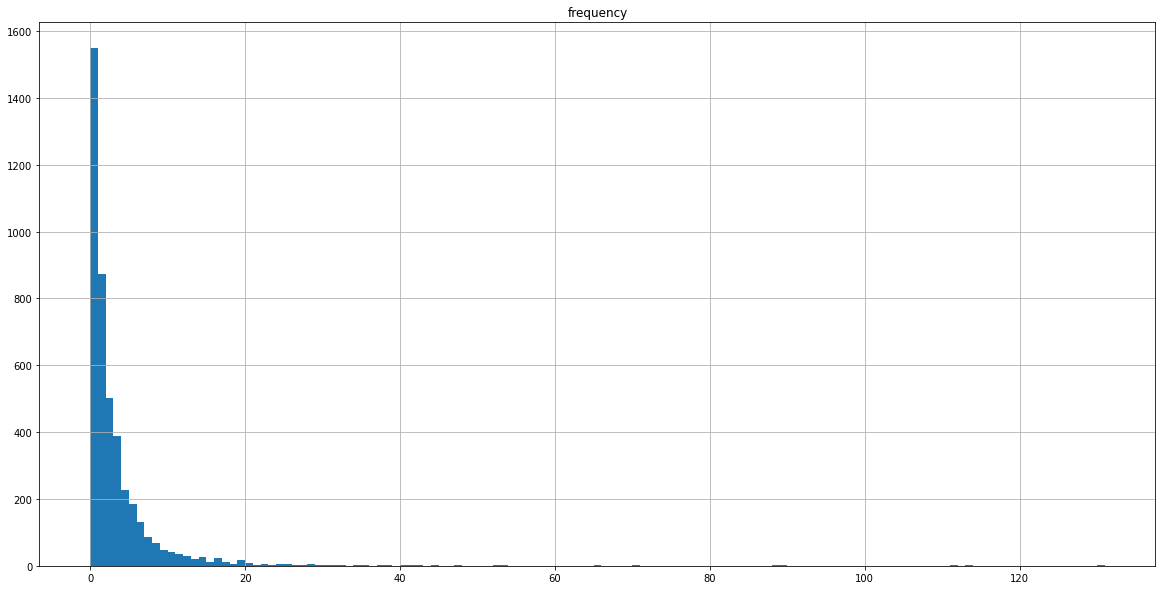

In [192]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import pandas as pd

xaction_RFM.hist(column='frequency', bins=131)

# 3.) Training Model to det. 'Alive-ness'

For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive `penalizer_coef` in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

In [193]:
from lifetimes import BetaGeoFitter

I2 = 0.0004

bgf = BetaGeoFitter(penalizer_coef = I2)
bgf.fit(xaction_RFM['frequency'], xaction_RFM['recency'], xaction_RFM['T'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.90, b: 0.00, r: 0.83>

## a.- Visualizing Model Frequency/Recency Matrix

### Recency_Frequency Plot

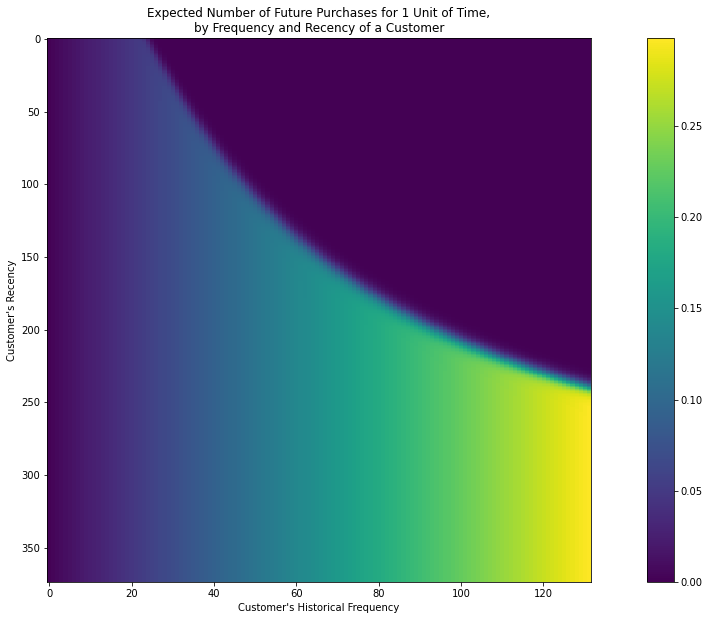

In [194]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

### 'Still Alive' Plot

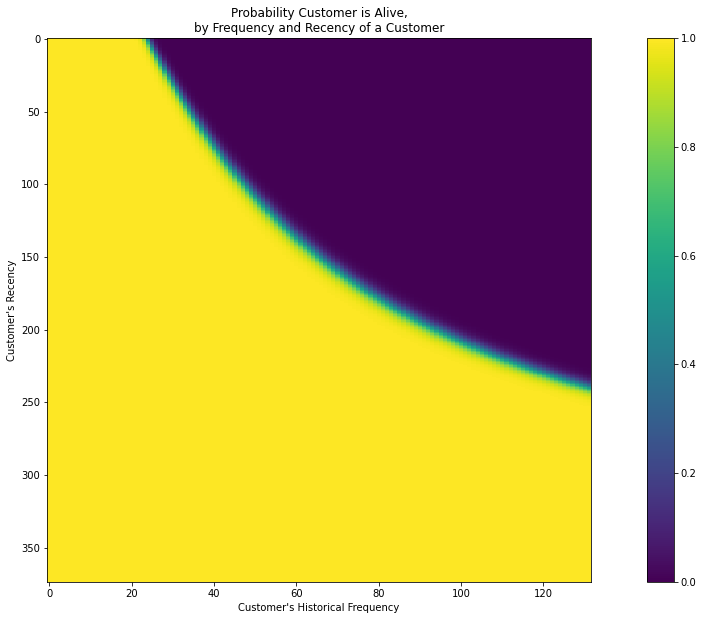

In [195]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

## b.- Rank customer from Best to Worst

The expected number of repeat purchases in the **next day** using their history.

In [196]:
t = 1  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase').tail(100)

,frequency,recency,T,monetary_value,predicted_purchase
CustomerID,,,,,
17381,19.0,364.0,372.0,1012.606842,0.044966
18041,19.0,361.0,372.0,197.602632,0.044966
14562,16.0,301.0,304.0,300.745000,0.045120
13685,5.0,58.0,60.0,357.056000,0.045193
16931,19.0,364.0,369.0,234.324737,0.045274
...,...,...,...,...,...
14606,88.0,372.0,373.0,135.890114,0.201008
15311,89.0,373.0,373.0,677.729438,0.203271
17841,111.0,372.0,373.0,364.452162,0.253056


The expected number of repeat purchases over the **next 3-days** using their history.

In [198]:
t = 3  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase').tail(100)

,frequency,recency,T,monetary_value,predicted_purchase
CustomerID,,,,,
17381,19.0,364.0,372.0,1012.606842,0.134897
18041,19.0,361.0,372.0,197.602632,0.134897
14562,16.0,301.0,304.0,300.745000,0.135361
13685,5.0,58.0,60.0,357.056000,0.135578
16931,19.0,364.0,369.0,234.324737,0.135821
...,...,...,...,...,...
14606,88.0,372.0,373.0,135.890114,0.603024
15311,89.0,373.0,373.0,677.729438,0.609813
17841,111.0,372.0,373.0,364.452162,0.759168


## c.- Split Data (training & validation)

Split data into a **training** (calibration) period and a **holdout** (observation) period.  Then, train the BG/NBD model and evaluate performance with four plots as outlined by [Peter Fader (26:10)](https://www.youtube.com/watch?v=guj2gVEEx4s)

#### Calibration period histogram

Compares the purchases between actual and what model's predicts.  The more similar in values between the two, the better.


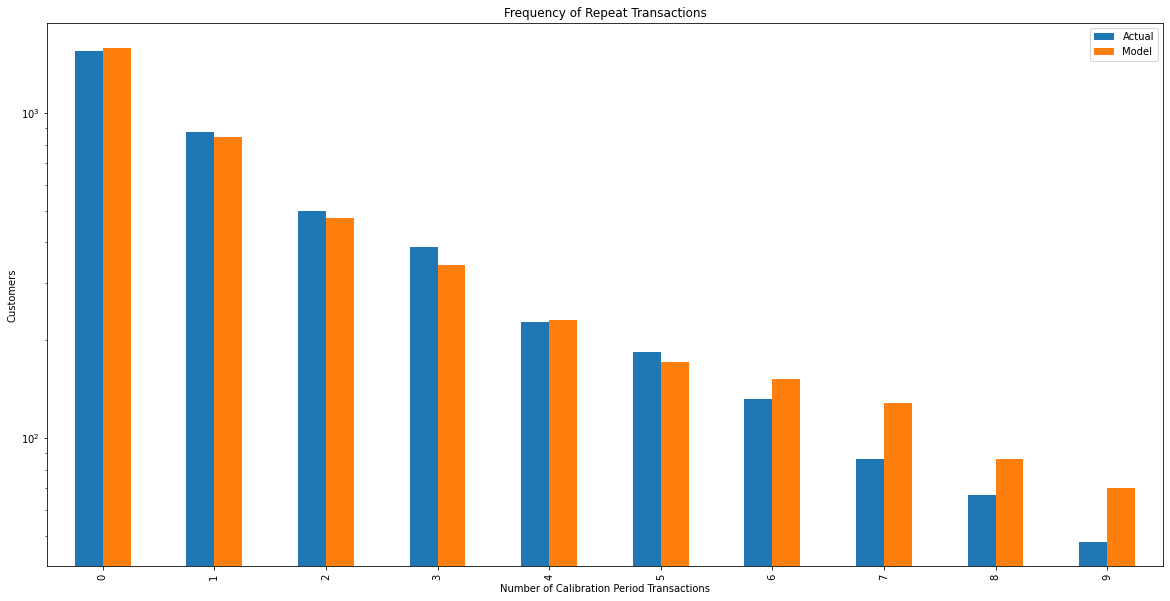

In [199]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency=10).set_yscale('log')

The model is fairly representative of the real data up until **third repeat** transactions.  This proves that our model doesn’t suck

#### Cumulative transaction plot

In [200]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(
    df,
    'CustomerID',
    'InvoiceDate',
    calibration_period_end = '2011-10-10', 
    observation_period_end = '2011-12-09'
)

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,265.0,0.0,60
12347,4.0,238.0,307.0,2.0,60
12348,3.0,283.0,298.0,0.0,60
12350,0.0,0.0,250.0,0.0,60
12352,5.0,224.0,236.0,1.0,60


In [202]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 3741 subjects, a: 0.00, alpha: 69.71, b: 0.00, r: 0.77>

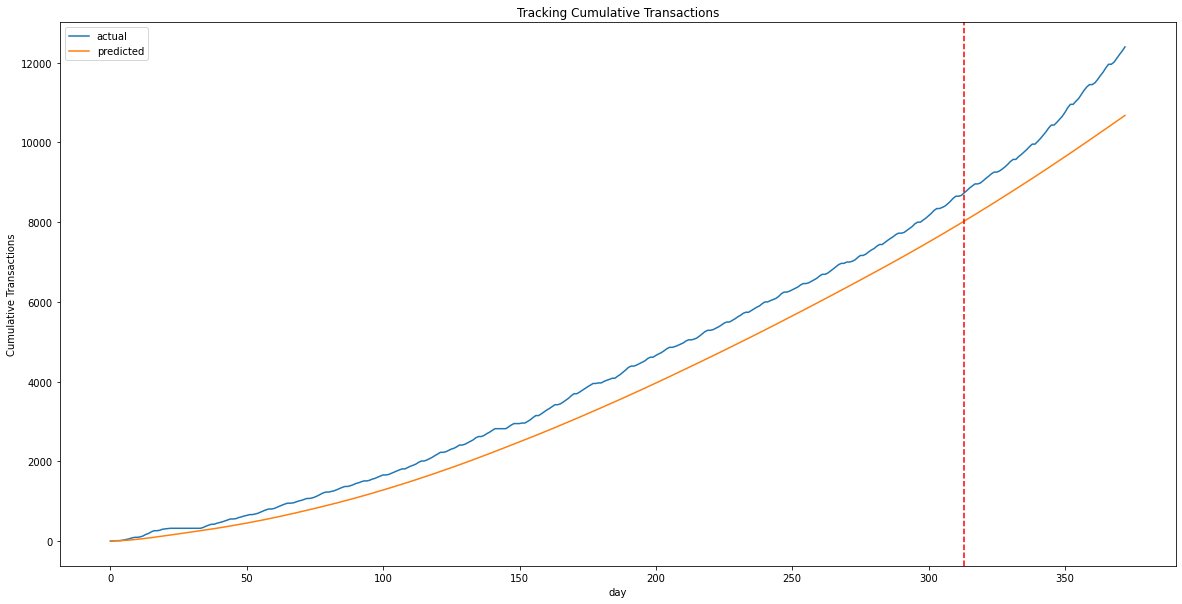

In [203]:
from lifetimes.plotting import plot_cumulative_transactions
plot_cumulative_transactions(bgf, df, 'InvoiceDate', 'CustomerID', 373, 313, freq='D');

The red line represents the boundary between the calibration period on the left and the holdout period on the right. 

As you can see, the BG/NBD model is not so greate in predicting cumulative transactions.

#### Incremental transaction plot

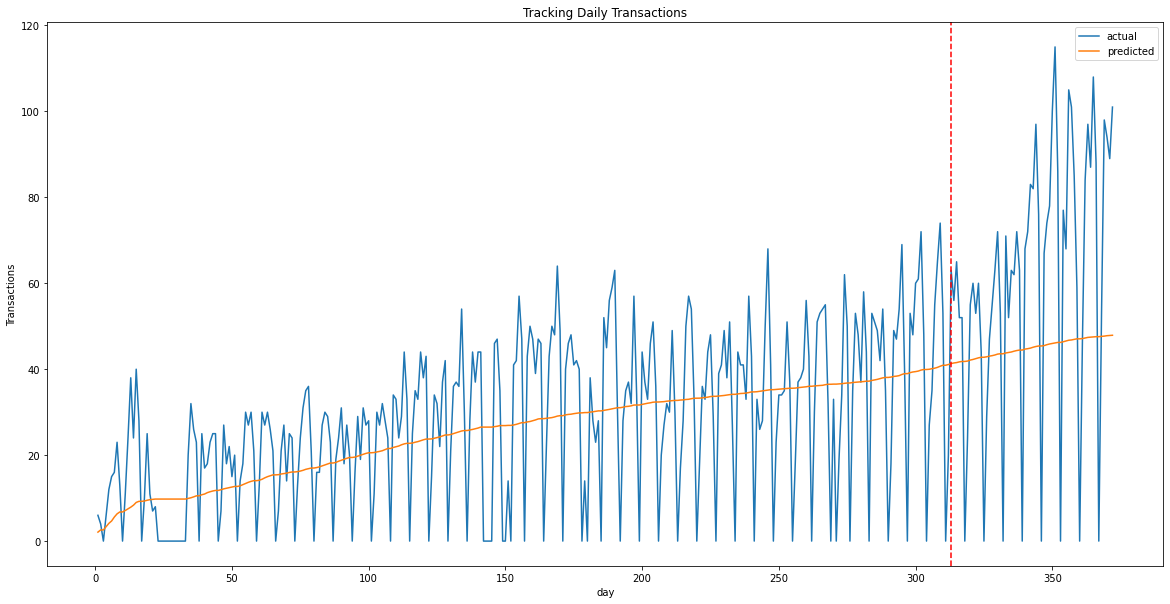

In [204]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(bgf, df, 'InvoiceDate', 'CustomerID', 373, 313, freq='D');

This plot shows that the model does only a decent job capturing general trends in the data.

#### Conditional expectations plot

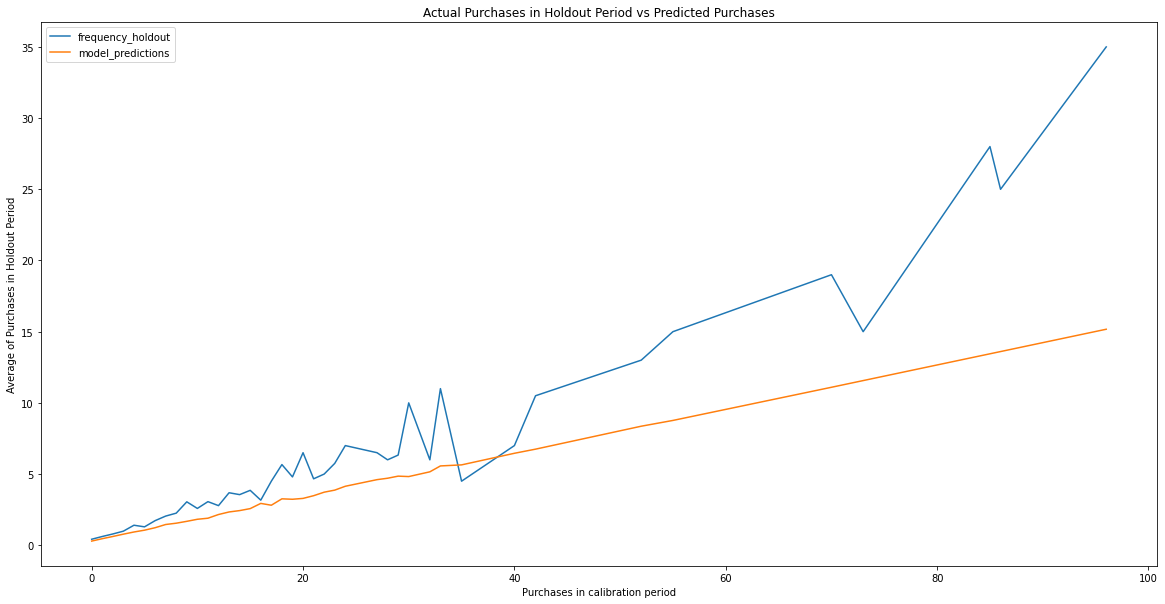

In [205]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=60)

The model performs OK up to about 30-days, but increasingly diverges from the holdout data because of thie distribution of the data.

In [206]:
df.groupby('CustomerID').size().value_counts()

10      78
11      74
6       73
9       73
5       72
        ..
741      1
705      1
2700     1
645      1
1637     1
Length: 461, dtype: int64

## d. Predictions

### Single Customer Prediction

Let's pick some customer and predict what that indivudla's future purchase might look like:

In [207]:
t = 3  #predict purchases in 3-days
individual = xaction_RFM.loc['14688', :]    # customerID = '13694'
bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    individual['frequency'], 
    individual['recency'], 
    individual['T']
)

0.13396757464999243

### Single Customer probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:

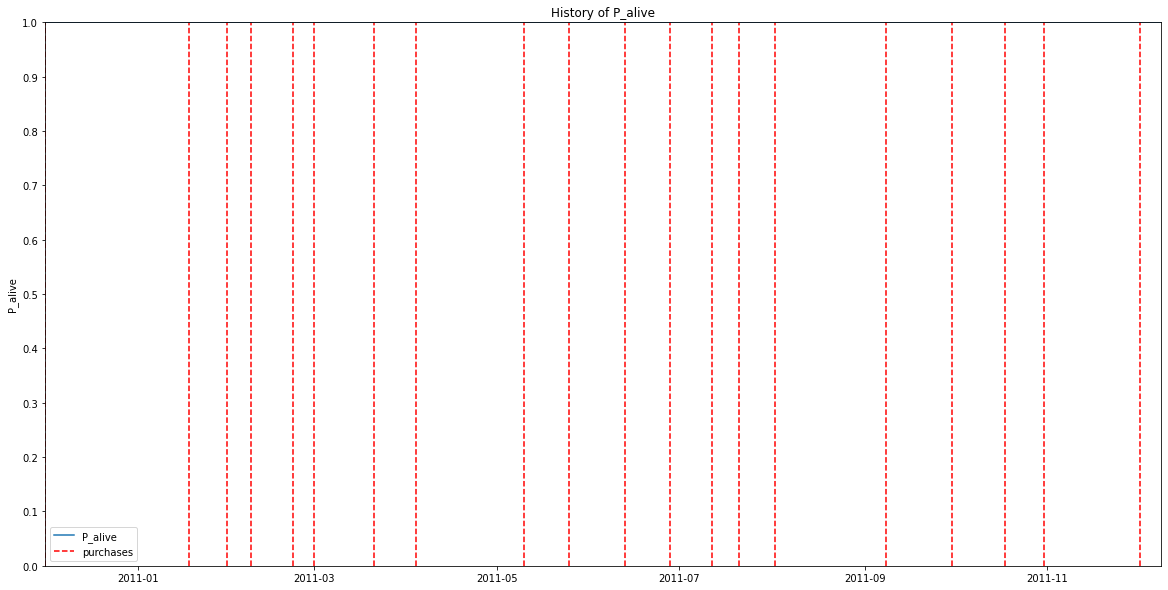

In [208]:
from lifetimes.plotting import plot_history_alive

customer_ID = '14688'
days_since_birth = 373
sp_trans = df.loc[df['CustomerID'] == customer_ID]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

#4.) Estimating CLV using Gamma-Gamma model

Until now, we have not taken into account the economics value of each transaction; rather, we've only been focusing on transactions' occurences.

In order to estimate CLV, we will use the `Gamma-Gama` submodel.

First, we shall create summary data from the transactional data that contains the economics values for each transaction (e.g., profits or revenues).

In [212]:
summary_with_money_value = xaction_RFM
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]
returning_customers_summary.head()

,frequency,recency,T,monetary_value,predicted_purchase
CustomerID,,,,,
12347,6.0,365.0,367.0,599.701667,0.046974
12348,3.0,283.0,358.0,301.480000,0.026882
12352,6.0,260.0,296.0,368.256667,0.056114
12356,2.0,303.0,325.0,269.905000,0.021518
12358,1.0,149.0,150.0,683.200000,0.025016


***NOTE***

If computing the monetary value from your own data, note that it is the mean of a given customer’s value, not the sum. monetary_value can be used to represent profit, or revenue, or any value as long as it is consistently calculated for each customer.

## a.- Gamma-Gamma Model && Independence Assumptions

The model we are going to use to estimate the CLV for our data is called the Gamma-Gamma submodel, which relies upon an important assumption. 

The Gamma-Gamma submodel assumes that **there is no relationship between the monetary value and the purchase frequency.** In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [213]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


Since there doesn't seem to be a high correlation between `Monetary Value` and `Purchase Frequency` (value of 0.015882), we can proceed in training our Gamma-Gamma submodel and predict the conditional, expected vaerage lifetime value of our customers.

## b.- Train Gamma-Gamma model

In [214]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
)
ggf

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

## c.- Est. Avg. Transaction Value

In [217]:
ggf.conditional_expected_average_profit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
).head(11)

CustomerID
12347     569.988807
12348     333.762672
12352     376.166864
12356     324.008941
12358     539.930643
12359    1515.282839
12360     652.217077
12362     514.793066
12363     341.147333
12364     282.075487
12370     585.986819
dtype: float64

In [218]:
print(
    "Expected conditional average revenue: %s, Average revenue: %s" % (
        ggf.conditional_expected_average_profit(
            returning_customers_summary['frequency'],
            returning_customers_summary['monetary_value']
        ).mean(),

        summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
    )
)

Expected conditional average revenue: 454.5701345329117, Average revenue: 477.3586892535673
